# **Airline Sentiment Prediction**

---


### **Problem Statement**

In this project you are dealing with the twitter US Airlines dataset. A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by the 'tweet_id', 'airline_sentiment_confidence','negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'. In this project you are going to apply the Glove pre-trained model to predict the tweets category.

### **About the dataset**

The data file train.csv contains the 10248 tweets with the 15 features including the target feature(airline_sentiment). The datafile test.csv contains the 4392 tweets with the 14 features excluding the target feature. The submission file contains the loan status ID and the airline_sentiment feature. Target feature airline_sentiment having categorical variable. We have already did the processing on the target features and you have to convert the features in the format which is given in the sample submission file.


### **Outcomes**
After completing this project, you will have the better understanding of how to do the word embedding using Glove vectors. In this project, you will apply the following concepts.

* Data cleaning
* Text processing
* Glove vector implementation
* Basic neural network

In [377]:
import numpy as np
import pandas as pd
from keras.utils import np_utils 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random as python_randomi
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
import warnings
warnings.filterwarnings("ignore")
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import nltk
from keras.utils import np_utils 

In [378]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Train Data**

---






In [379]:
#train data
path='/content/gdrive/My Drive/Word Embeddings/train.csv'
train=pd.read_csv(path)
train.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,568161313274404864,1,1.000,NaN,NaN,Southwest,NaN,Rickonia,NaN,0,@SouthwestAir yall still fly in the cold right?,NaN,2015-02-18 13:33:07 -0800,Zamunda,Pacific Time (US & Canada)
1,568175282919739392,0,1.000,Late Flight,1.0000,US Airways,NaN,Scscottish,NaN,0,"@usairways. Seriously, attendants go AWOL for ...",NaN,2015-02-18 14:28:38 -0800,Proud to say I'm from Dundee,Atlantic Time (Canada)
2,569259238989688833,0,1.000,Late Flight,0.3488,Southwest,NaN,desh9583,NaN,0,@SouthwestAir - holding us hostage for about a...,NaN,2015-02-21 14:15:53 -0800,NaN,NaN
3,569787479324299265,0,1.000,Lost Luggage,1.0000,American,NaN,Rom55Weber,NaN,1,@AmericanAir i've now been in France two days ...,NaN,2015-02-23 01:14:55 -0800,NaN,Paris
4,568946825798905856,2,0.343,NaN,0.0000,United,NaN,nfriesen1,NaN,0,@united give her the recognition she deserves!,NaN,2015-02-20 17:34:28 -0800,"Winnipeg, MB Canada",Central Time (US & Canada)


## **Test Data**

---



In [380]:
#test data
path='/content/gdrive/My Drive/Word Embeddings/test.csv'
test=pd.read_csv(path)
test.head(5)

,tweet_id,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569619309401546752,1.0000,NaN,NaN,Southwest,NaN,katiefranci,NaN,0,@SouthwestAir your hold music sounds like it's...,NaN,2015-02-22 14:06:41 -0800,NaN,Central Time (US & Canada)
1,567996668320346112,0.6556,NaN,NaN,Southwest,NaN,PaytonTaylor129,NaN,1,"@SouthwestAir Today is going to be the day, I ...",NaN,2015-02-18 02:38:53 -0800,"Nashville, TN",Quito
2,568881975177515009,1.0000,Flight Booking Problems,1.0,US Airways,NaN,bulezim,NaN,0,@USAirways why I can't book a flight to PRN th...,NaN,2015-02-20 13:16:46 -0800,Somewhere in the Milky Way,Eastern Time (US & Canada)
3,569524522291892226,0.6735,NaN,0.0,US Airways,NaN,dailylaurel,NaN,0,@USAirways i ve been told that you get a perce...,NaN,2015-02-22 07:50:02 -0800,Bruxelle-Paris-Marseille-(BPM),Athens
4,569747533641199617,1.0000,Can't Tell,1.0,US Airways,NaN,FallNightLights,NaN,1,@USAirways is the worst airline to ever travel...,NaN,2015-02-22 22:36:12 -0800,Detroit - Hampton U.,Quito


## **Preprocessing**

---



In [381]:
ord_reason={'Customer Service Issue':1,'Late Flight':2,'''Can't Tell''':3,'Cancelled Flight':4,'Lost Luggage':5,'Flight Booking Problems':6,'Bad Flight':7,'Flight Attendant Complaints':8,'longlines':9,'Damaged Luggage':10}

train['negativereason']=train['negativereason'].map(ord_reason)
test['negativereason']=train['negativereason'].map(ord_reason)


In [382]:
train['negativereason'].fillna(0,inplace=True)
test['negativereason'].fillna(0,inplace=True)

In [383]:
train['negativereason_confidence'].fillna(0,inplace=True)
test['negativereason_confidence'].fillna(0,inplace=True)

In [384]:
ord_airline_train={'United':1,'US Airways':2,'American':3,'Southwest':4,'Delta':5,'Virgin America':6}
train['airline']=train['airline'].map(ord_airline_train)
ord_airline_test={'United':1,'US Airways':2,'American':3,'Southwest':4,'Delta':5,'Virgin America':6}
test['airline']=test['airline'].map(ord_airline_test)


## **Installing Required Libraries**

---



In [385]:
pip install emoji

In [386]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [387]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## **Creating Additional Features**

---



In [388]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import re
import string
import os
import emoji
import textblob
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):     
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        pos_family = {
                        'noun' : ['NN','NNS','NNP','NNPS'],
                        'pron' : ['PRP','PRP$','WP','WP$'],
                        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
                        'adj' :  ['JJ','JJR','JJS'],
                        'adv' : ['RB','RBR','RBS','WRB']
                     }

        # function to check and get the part of speech tag count of a words in a given sentence
        def check_pos_tag(x, flag):
            cnt = 0
            try:
                wiki = textblob.TextBlob(x)
                for tup in wiki.tags:
                    ppo = list(tup)[1]
                    if ppo in pos_family[flag]:
                        cnt += 1
            except:
                pass
            return cnt
        count_noun = X.apply(lambda x: check_pos_tag(x, 'noun'))
        count_verb = X.apply(lambda x: check_pos_tag(x, 'verb'))
        count_adj = X.apply(lambda x: check_pos_tag(x, 'adj'))
        count_adv = X.apply(lambda x: check_pos_tag(x, 'adv'))
        count_pron = X.apply(lambda x: check_pos_tag(x, 'pron'))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                           , 'count_noun' : count_noun
                           , 'count_verb' : count_verb
                           , 'count_adj' : count_adj 
                           , 'count_adv' : count_adv
                           , 'count_pron' : count_pron
                          })
        
        return df


tc = TextCounts()
train_eda= tc.fit_transform(train['text'])
test_eda= tc.transform(test['text'])


train_eda          

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron
0,8,1,0,0,1,0,0,3,1,2,1,0
1,22,1,0,1,0,1,0,10,3,0,4,0
2,24,2,0,1,0,0,0,7,5,0,2,4
3,28,1,0,0,0,0,0,7,6,3,2,3
4,7,1,0,0,1,0,0,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
10243,10,1,0,1,0,0,0,2,3,1,0,2
10244,27,1,0,0,1,0,0,11,5,1,3,3
10245,14,1,1,0,2,0,0,3,4,2,1,2
10246,23,1,0,0,0,0,0,7,6,4,3,1


In [389]:
test_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron
0,15,1,0,0,0,0,0,8,2,1,0,2
1,25,1,1,0,3,0,0,10,6,0,0,4
2,13,1,0,1,1,0,0,6,0,0,2,2
3,25,1,0,0,0,0,0,8,7,1,1,1
4,9,1,0,0,0,0,0,3,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4387,21,1,0,0,0,0,0,6,2,3,5,2
4388,28,1,0,0,0,0,0,7,6,1,4,3
4389,3,1,0,0,0,0,0,2,0,1,0,0
4390,23,3,0,0,2,0,0,8,6,1,2,1


In [390]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [391]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [392]:
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
#Lemmatization of data
from nltk.stem import WordNetLemmatizer
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')+['link','quot','amp']
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 2] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = WordNetLemmatizer()
        words = input_text.split() 
        stemmed_words = [porter.lemmatize(word) for word in words]
        return " ".join(stemmed_words)

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X


ct = CleanText()
train['text_clean'] = ct.fit_transform(train.text)
test['text_clean'] = ct.fit_transform(test.text)
     




In [393]:
train_new=train[['text_clean','airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment']]
test_new=test[['text_clean','airline_sentiment_confidence','negativereason','negativereason_confidence','airline']]
train_new_final=pd.concat([train_new,train_eda],1)
test_new_final=pd.concat([test_new,test_eda],1)

In [394]:
train_new_final.head(5)

,text_clean,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron
0,yall still fly cold right,1.000,0.0,0.0000,4,1,8,1,0,0,1,0,0,3,1,2,1,0
1,seriously attendant awol min flight delayed li...,1.000,2.0,1.0000,2,0,22,1,0,1,0,1,0,10,3,0,4,0
2,holding hostage hour update taking not going,1.000,2.0,0.3488,4,0,24,2,0,1,0,0,0,7,5,0,2,4
3,france two day without changing clothes nothin...,1.000,5.0,1.0000,3,0,28,1,0,0,0,0,0,7,6,3,2,3
4,give recognition deserves,0.343,0.0,0.0000,1,2,7,1,0,0,1,0,0,1,2,1,1,2


In [395]:
test_new_final.head(5)

,text_clean,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron
0,hold music sound like super mario bros gameboy...,1.0000,0.0,0.0,4,15,1,0,0,0,0,0,8,2,1,0,2
1,today going day feel thank support throughout ...,0.6556,0.0,0.0,4,25,1,1,0,3,0,0,10,6,0,0,4
2,book flight prn website,1.0000,0.0,1.0,2,13,1,0,1,1,0,0,6,0,0,2,2
3,told get percentage every plastic bottle sold ...,0.6735,0.0,0.0,2,25,1,0,0,0,0,0,8,7,1,1,1
4,worst airline ever travel,1.0000,0.0,1.0,2,9,1,0,0,0,0,0,3,2,1,1,0


In [396]:
#Wordcloud
!pip install wordcloud

Positive words


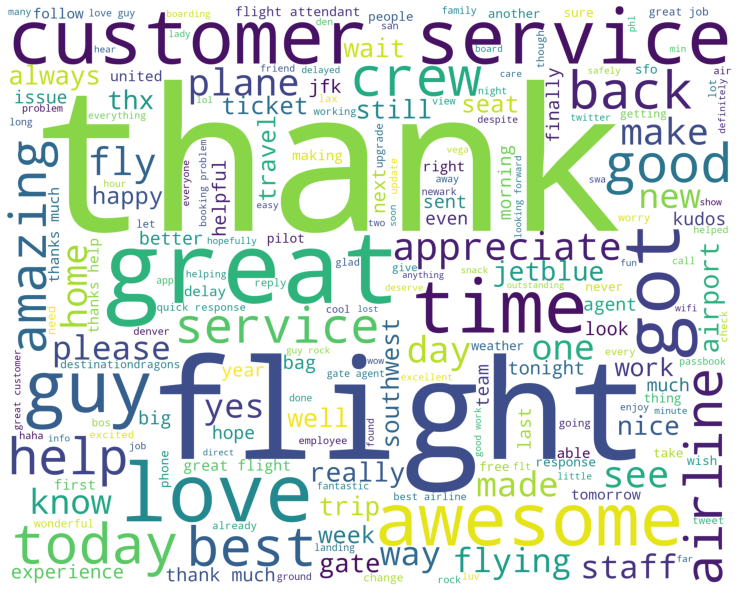

In [274]:
from wordcloud import WordCloud,STOPWORDS
train_pos = train[train['airline_sentiment'] ==2]
train_pos = train_pos['text_clean']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')

neutral words


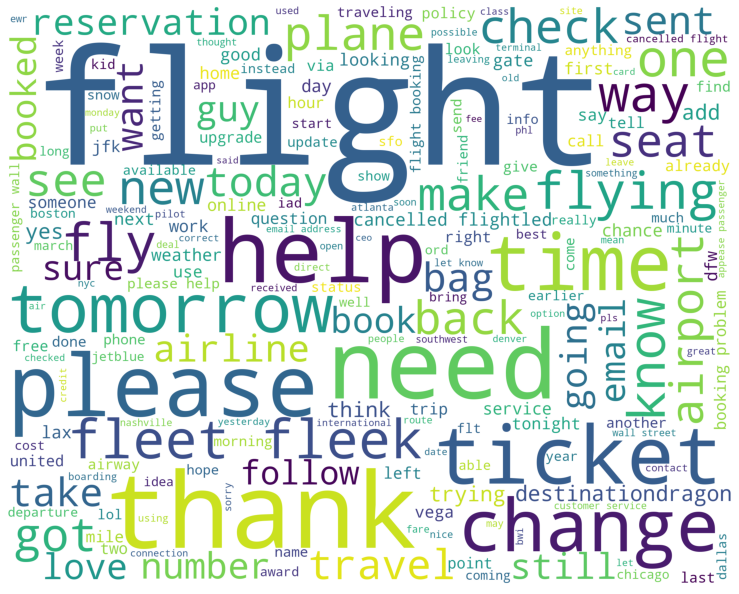

In [99]:
from wordcloud import WordCloud
train_pos = train[train['airline_sentiment'] ==1]
train_pos = train_pos['text_clean']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("neutral words")
wordcloud_draw(train_pos,'white')

negative words


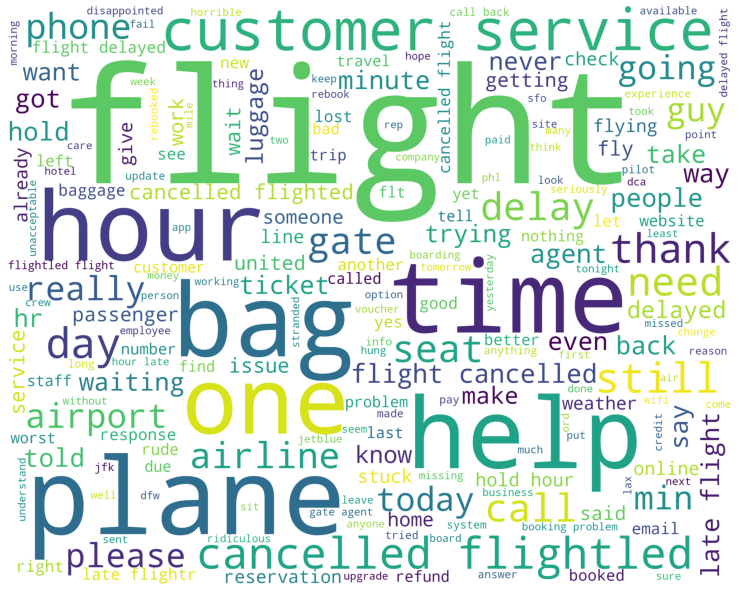

In [100]:
from wordcloud import WordCloud
train_pos = train[train['airline_sentiment'] ==0]
train_pos = train_pos['text_clean']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("negative words")
wordcloud_draw(train_pos,'white')

In [403]:
#Max length of text sentence
max_len=max([len(s.split()) for s in train_new_final['text_clean']])

In [404]:
max_len

20

In [405]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [406]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [409]:
x = train_new_final['text_clean']
y = train_new_final['airline_sentiment']

#Tokenization of text data
token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)

#Converting the tokenized data into sequence of words
pad_seq = pad_sequences(seq,padding='post',maxlen=20)

#Set the vocab size
vocab_size = len(token.word_index)+1

In [410]:
#Drop the two columns
train_new_final.drop(['text_clean','airline_sentiment'],1,inplace=True)

In [411]:
#pad sequence array
pad_seq

array([[ 533,   20,   35, ...,    0,    0,    0],
       [ 255,  154, 4208, ...,    0,    0,    0],
       [ 502, 1267,    4, ...,    0,    0,    0],
       ...,
       [ 203,   76,    8, ...,    0,    0,    0],
       [ 378,  318,    9, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [338]:
#Calculated vocab size
vocab_size

8567

## **Word Embeddings**

---



In [339]:
#Load embeddings into memory
embeddings_index=dict()
f='/content/gdrive/My Drive/Word Embeddings/glove.6B.50d.txt'

import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


In [340]:
#Creating Embedding Matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/gdrive/My Drive/Word Embeddings/glove.6B.50d.txt',token.word_index, embedding_dim)

In [341]:
#Finding the percentage of text data covered by embedding matrix
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7918758024979573

In [342]:
#Embedding matrix
embedding_matrix=pd.DataFrame(embedding_matrix)
embedding_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,1.73060,0.28400,-0.040613,-0.087372,-0.481900,-0.427800,-0.65733,0.316320,1.055400,-0.709090,0.57747,0.36280,-0.467170,0.97844,0.126950,-0.39876,-1.64320,0.346160,-1.969900,-0.40326,0.275430,0.70050,-0.24267,-0.004251,0.34004,-1.60210,0.06427,0.035409,0.33291,0.25677,2.26110,0.955950,-0.557610,-0.12359,0.740870,-0.474270,0.89383,-0.022107,-0.38237,0.87486,-0.132630,0.069306,1.116600,0.443550,-0.849210,0.039591,0.34486,0.340120,-0.097281,0.280050
2,0.55025,-0.24942,-0.000939,-0.264000,0.593200,0.279500,-0.25666,0.093076,-0.362880,0.090776,0.28409,0.71337,-0.475100,-0.24413,0.884240,0.89109,0.43009,-0.273300,0.112760,-0.81665,-0.412720,0.17754,0.61942,0.104660,0.33327,-2.31250,-0.52371,-0.021898,0.53801,-0.50615,3.86830,0.166420,-0.719810,-0.74728,0.116310,-0.375850,0.55520,0.126750,-0.22642,-0.10175,-0.354550,0.123480,0.165320,0.704200,-0.080231,-0.068406,-0.67626,0.337630,0.050139,0.334650
3,0.15910,-0.21428,0.630990,-0.599500,0.312480,-0.166150,-0.90548,0.451150,0.051568,0.259100,-0.32882,0.48155,-0.349820,0.12905,1.075800,0.48690,0.53420,0.059762,0.216600,-1.10590,-0.255910,0.57462,0.54562,0.310430,0.37765,-2.03370,-0.22496,0.184470,0.82587,-1.19910,3.60420,1.160500,-0.597870,0.13000,0.156780,0.131660,0.18510,0.363080,0.57538,-0.89593,-0.363660,0.283970,0.048614,0.787800,-0.087311,-0.233940,-0.14237,0.021215,-0.142190,0.669550
4,0.49603,0.57870,0.166380,-0.133940,0.094386,-0.323010,-0.10589,0.519310,0.114090,0.100800,-1.12560,-1.12970,-0.107570,0.57863,0.859620,-0.62181,-0.70217,0.214400,-1.331900,-0.54315,0.949910,1.02130,0.50037,0.265390,0.53437,-0.68183,0.79417,0.459810,0.58345,0.27078,3.35280,0.566030,-0.425340,0.71726,0.179170,-0.154750,0.66508,0.112390,0.17412,0.28794,-0.042736,0.637440,-0.285240,-0.072494,-0.583780,0.029726,0.71582,-0.362790,-0.417920,0.713480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8562,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8563,0.78563,-0.21890,-0.557350,-0.088309,0.613950,-0.180060,0.56121,0.411210,-0.453520,0.897020,-0.72458,-0.26706,-0.038551,0.40180,0.520200,0.19458,-0.26381,-0.331760,0.003855,-0.18764,-0.143250,0.66360,-0.22010,0.022057,1.14740,-0.29403,-0.96131,0.862410,0.98086,0.48024,0.57048,-0.017545,0.998170,-1.34980,-0.260540,-0.129940,-0.65488,-0.095915,-0.65332,-0.79562,-0.314650,0.123580,0.182130,0.340640,0.256160,0.764200,0.73279,1.107900,0.197310,0.388890
8564,0.30156,-0.57020,-0.847870,-0.496070,1.493200,-0.048381,0.18675,-0.253800,-0.186420,0.361370,0.14600,0.10081,-0.265550,0.91748,-0.176330,0.26494,0.75055,-0.028512,0.384170,-1.17550,-0.691780,0.52026,0.37735,0.098482,0.72353,-0.54952,-0.30042,1.341000,0.89278,-0.83808,2.34050,-0.394810,-0.082844,-0.17238,0.095875,-0.057885,0.40892,1.636800,-0.69066,-0.44235,0.410630,-0.316160,0.056133,0.442630,-0.422590,-0.053154,0.21780,-0.096713,0.282140,0.668950
8565,-0.57074,-0.53652,0.062869,-0.416420,-0.325250,0.436750,0.58837,-0.0957

In [412]:
vocab_size

8567

In [413]:
pad_seq=pd.DataFrame(pad_seq)
X=pad_seq
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,533,20,35,534,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,255,154,4208,36,1,25,4209,705,486,0,0,0,0,0,0,0,0,0,0,0
2,502,1267,4,135,308,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2422,95,19,212,595,624,141,128,678,18,1268,11,240,0,0,0,0,0,0,0
4,100,3035,1360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,134,14,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10244,2,3,161,1415,304,1932,1,231,1,161,304,0,0,0,0,0,0,0,0,0
10245,203,76,8,54,284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10246,378,318,9,703,493,18,17,21,34,145,8566,839,2,111,1449,0,0,0,0,0


## **Target Data**

---



In [414]:
y=pd.DataFrame(y)
y
labels = np_utils.to_categorical(y)
print('Shape of label tensor:', labels.shape)

Shape of label tensor: (10248, 3)


## **Creating Train Data for Modelling**

---



In [415]:
train=pd.concat([X,train_new_final],1)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron
0,533,20,35,534,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0000,0.0,0.0000,4,8,1,0,0,1,0,0,3,1,2,1,0
1,255,154,4208,36,1,25,4209,705,486,0,0,0,0,0,0,0,0,0,0,0,1.0000,2.0,1.0000,2,22,1,0,1,0,1,0,10,3,0,4,0
2,502,1267,4,135,308,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0000,2.0,0.3488,4,24,2,0,1,0,0,0,7,5,0,2,4
3,2422,95,19,212,595,624,141,128,678,18,1268,11,240,0,0,0,0,0,0,0,1.0000,5.0,1.0000,3,28,1,0,0,0,0,0,7,6,3,2,3
4,100,3035,1360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.3430,0.0,0.0000,1,7,1,0,0,1,0,0,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,134,14,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0000,0.0,0.0000,4,10,1,0,1,0,0,0,2,3,1,0,2
10244,2,3,161,1415,304,1932,1,231,1,161,304,0,0,0,0,0,0,0,0,0,0.6639,0.0,0.0000,6,27,1,0,0,1,0,0,11,5,1,3,3
10245,203,76,8,54,284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.6444,0.0,0.0000,4,14,1,1,0,2,0,0,3,4,2,1,2
10246,378,318,9,703,493,18,17,21,34,145,8566,839,2,111,1449,0,0,0,0,0,1.0000,1.0,1.0000,3,23,1,0,0,0,0,0,7,6,4,3,1


## **Train Test Split**

---



In [352]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train,labels,test_size=0.2,random_state=9)

In [353]:
X_train.shape,X_test.shape

((8198, 36), (2050, 36))

In [354]:
y_train.shape,y_test.shape

((8198, 3), (2050, 3))

## **Creating A Gru based Deep learning network**

---



In [357]:
# Importing Libraries
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,Flatten,Bidirectional,SimpleRNN,GRU
import tensorflow as tf
import random as python_random
import random as python_random

#Reproducibility of Results
np.random.seed(9)
python_random.seed(9)
tf.random.set_seed(9)

#Creating the model
model = Sequential()

#Adding Embedding Layer
model.add(Embedding(vocab_size,50,weights=[embedding_matrix],input_length=36,trainable=False))

#Adding GRU Layer
model.add(GRU(812))

#Adding Dropout Layer
model.add(Dropout(0.3))

#Add hidden Layer
model.add(Dense(256))
model.add(Dense(128))

#Add Dropout Layer
model.add(Dropout(0.2))
model.add(Dense(3,activation = 'softmax'))

#Comile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

#Adding Callbacks
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

early_stop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)


#Fit the model
model.fit(X_train, y_train,epochs=30,verbose=2,validation_data=(X_test, y_test),batch_size=200,callbacks=[early_stop,reduce_lr])

#Calculate Accuracy for train data and test data
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 36, 50)            428350    
_________________________________________________________________
gru_40 (GRU)                 (None, 812)               2104704   
_________________________________________________________________
dropout_64 (Dropout)         (None, 812)               0         
_________________________________________________________________
dense_115 (Dense)            (None, 256)               208128    
_________________________________________________________________
dense_116 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 3)               

## **Predicting on Test Data**

In [358]:
x = test_new_final['text_clean']
token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq,padding='post',maxlen=20)

In [360]:
pad_seq=pd.DataFrame(pad_seq)

In [362]:
pad_seq

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,14,604,664,33,340,2550,2551,2552,2553,0,0,0,0,0,0,0,0,0,0,0
1,25,48,20,413,17,605,1440,341,65,498,2554,0,0,0,0,0,0,0,0,0
2,125,1,2555,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,63,3,2556,176,1174,1441,1009,330,2557,239,1175,1442,2558,0,0,0,0,0,0,0
4,96,19,81,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,184,9,7,102,881,2,839,454,354,8,505,0,0,0,0,0,0,0,0,0
4388,262,20,29,1,204,470,413,205,942,5369,1012,5370,162,0,0,0,0,0,0,0
4389,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4390,803,185,5371,43,62,146,121,66,5372,602,0,0,0,0,0,0,0,0,0,0


In [364]:
test=pd.concat([pad_seq,test_new_final],1)
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,text_clean,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_noun,count_verb,count_adj,count_adv,count_pron,airline_sentiment
0,14,604,664,33,340,2550,2551,2552,2553,0,0,0,0,0,0,0,0,0,0,0,hold music sound like super mario bros gameboy...,1.0000,0.0,0.0000,4,15,1,0,0,0,0,0,8,2,1,0,2,-1
1,25,48,20,413,17,605,1440,341,65,498,2554,0,0,0,0,0,0,0,0,0,today going day feel thank support throughout ...,0.6556,0.0,0.0000,4,25,1,1,0,3,0,0,10,6,0,0,4,-1
2,125,1,2555,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,book flight prn website,1.0000,0.0,1.0000,2,13,1,0,1,1,0,0,6,0,0,2,2,-1
3,63,3,2556,176,1174,1441,1009,330,2557,239,1175,1442,2558,0,0,0,0,0,0,0,told get percentage every plastic bottle sold ...,0.6735,0.0,0.0000,2,25,1,0,0,0,0,0,8,7,1,1,1,-1
4,96,19,81,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,worst airline ever travel,1.0000,0.0,1.0000,2,9,1,0,0,0,0,0,3,2,1,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,184,9,7,102,881,2,839,454,354,8,505,0,0,0,0,0,0,0,0,0,disappointed customer service right definitely...,1.0000,0.0,1.0000,4,21,1,0,0,0,0,0,6,2,3,5,2,-1
4388,262,20,29,1,204,470,413,205,942,5369,1012,5370,162,0,0,0,0,0,0,0,landed day late flight almost sleep feel sorry...,0.6786,0.0,0.3563,1,28,1,0,0,0,0,0,7,6,1,4,3,-1
4389,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,flight,1.0000,0.0,0.0000,3,3,1,0,0,0,0,0,2,0,1,0,0,-1
4390,803,185,5371,43,62,146,121,66,5372,602,0,0,0,0,0,0,0,0,0,0,save checked snowboard trying check morning we...,1.0000,0.0,0.0000,1,23,3,0,0,2,0,0,8,6,1,2,1,-1


In [365]:
test.drop(['text_clean','airline_sentiment'],1,inplace=True)

In [368]:
B=model.predict_classes(test)
B

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 0, ..., 1, 1, 0])

In [371]:
B=pd.DataFrame(B)
B.columns=['Sentiment']
B['Sentiment'].value_counts()

1    2453
0    1033
2     906
Name: Sentiment, dtype: int64

In [372]:
#Final Predictions
B

,Sentiment
0,1
1,1
2,0
3,1
4,0
...,...
4387,0
4388,1
4389,1
4390,1


In [419]:
B.to_csv('Submit.csv',index=False)

In [420]:
from google.colab import files
files.download('Submit.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>